In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [5]:
# Import libraries here
import re
from glob import glob

import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

In [6]:
#preparing data


In [7]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in city, less than 100,000
    mask_apt = df["property_type"] == "apartment"
    mask_loc = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_apt & mask_loc & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns=["lat-lon"], inplace=True)

    # Extract "borough"
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    df.drop(columns=["place_with_parent_names"], inplace=True)

    # Drop feature with high null count
    df.drop(columns=["surface_total_in_m2", "price_usd_per_m2", "floor", "rooms", "expenses"], inplace=True)

    # Drop low- and high- categorical variables
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)

    # Drop leaky columns
    df.drop(columns=["price", "price_aprox_local_currency", "price_per_m2"], inplace=True)

    # Drop columns with multi-collinearity
    #df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)

    return df


In [8]:
# test your wrangle function on the file `mexico-city-real-estate-1.csv`
frame1 = wrangle('data/mexico-city-real-estate-1.csv')
frame1.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


In [9]:
files = glob("data/mexico-city-real-estate-*.csv")
# Sort files numerically based on the number in the filename
files.sort(key=lambda x: int(re.search(r'(\d+)', x).group()))

print(files)

['data/mexico-city-real-estate-1.csv', 'data/mexico-city-real-estate-2.csv', 'data/mexico-city-real-estate-3.csv', 'data/mexico-city-real-estate-4.csv', 'data/mexico-city-real-estate-5.csv']


In [11]:
frames = []
for file in files:
    df = wrangle(file)
    frames.append(df)

df = pd.concat(frames,ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 213.9+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,94022.66,57.0,23.634501,-102.552788,Benito Juárez
1,70880.12,56.0,19.402413,-99.095391,Iztacalco
2,68228.99,80.0,19.357820,-99.149406,Benito Juárez
3,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
4,94140.20,50.0,19.354219,-99.126244,Coyoacán


Exploring data

Text(0.5, 1.0, 'Distribution of Apartment Prices')

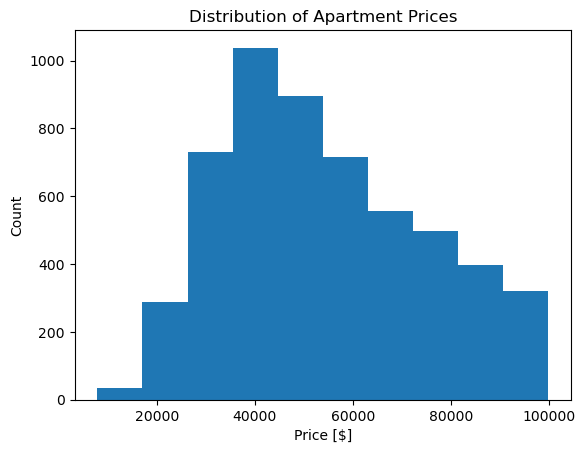

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots() 

# Plot the histogram on the axes object
ax.hist(df["price_aprox_usd"]) 

# Label axes using the axes 
ax.set_xlabel("Price [$]")
ax.set_ylabel("Count")


# Add title 
ax.set_title("Distribution of Apartment Prices")

Text(0.5, 1.0, 'Mexico City: Price vs. Area')

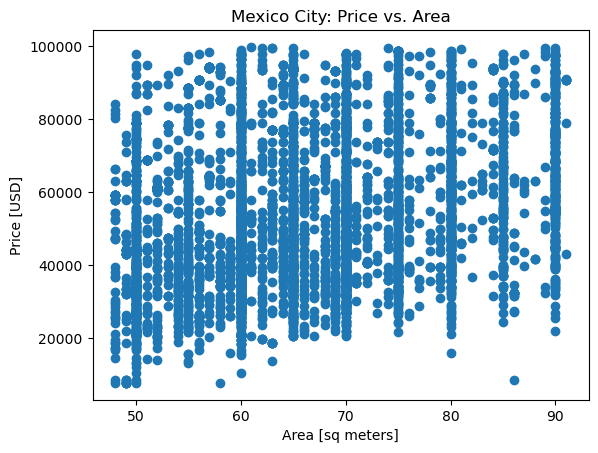

In [15]:
fig, ax = plt.subplots() 

# Create the scatter plot on the axes object
ax.scatter(df["surface_covered_in_m2"], df["price_aprox_usd"]) 

# Label axes 
ax.set_xlabel("Area [sq meters]" )
ax.set_ylabel("Price [USD]")

#  Add title 
ax.set_title("Mexico City: Price vs. Area")

In [17]:
# Plot Mapbox location and price

#fig = px.scatter_mapbox#(
    #df,
    #lat="lat",
   # lon="lon",
    #width=...,
   ## color=...,
#)


#fig.show()

In [18]:
# Split data into feature matrix `X_train` and target vector `y_train`.
target = "price_aprox_usd"
features = ["surface_covered_in_m2", "lat", "lon", "borough"]
X_train = df[features]
y_train = df[target]

In [21]:
# Calculate Baseline
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54246.5314982642
Baseline MAE: 17239.939475888295


In [27]:
# Correct OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)


# Build the pipeline
model = make_pipeline(
    encoder,
    SimpleImputer(),   # Be careful where you put this — see note below
    Ridge()
)

In [30]:
model.fit(X_train, y_train)

,steps,"[('onehotencoder', ...), ('simpleimputer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None


In [31]:
X_test = pd.read_csv("data/mexico-city-test-features.csv")
print(X_test.info())
X_test.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   float64
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(3), object(1)
memory usage: 32.7+ KB
None


,surface_covered_in_m2,lat,lon,borough
0,60.0,19.493185,-99.205755,Azcapotzalco
1,55.0,19.307247,-99.166700,Coyoacán
2,50.0,19.363469,-99.010141,Iztapalapa
3,60.0,19.474655,-99.189277,Azcapotzalco
4,74.0,19.394628,-99.143842,Benito Juárez


In [32]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    36404.255463
1    55373.844385
2    20133.723072
3    35385.350292
4    77194.243550
dtype: float64

In [36]:
# retrieve intercept
intercept = model.named_steps["ridge"].intercept_

# retrieve coefficients
coefficients = model.named_steps["ridge"].coef_

# retrieve feature names
features = model.named_steps["onehotencoder"].get_feature_names_out()

# create a series of names and values
feat_imp = pd.Series(coefficients, index=features)

feat_imp = feat_imp.sort_values(key=abs, ascending=True)
feat_imp


lon_-99.172286        -8.842327
lat_19.440147         -8.842327
lon_-99.120576        11.191327
lat_19.459485         11.191327
lon_-99.176701       -18.033434
                       ...     
lat_19.373446     -21098.460488
lat_19.413992      21366.945397
lat_19.3731619     21541.728932
borough_Tláhuac   -21592.863441
lat_19.400097      25340.686265
Length: 3965, dtype: float64

Text(0.5, 1.0, 'Feature Importances for Apartment Price')

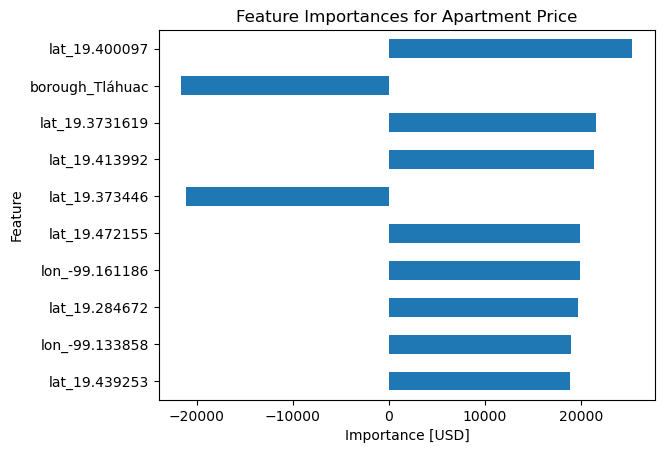

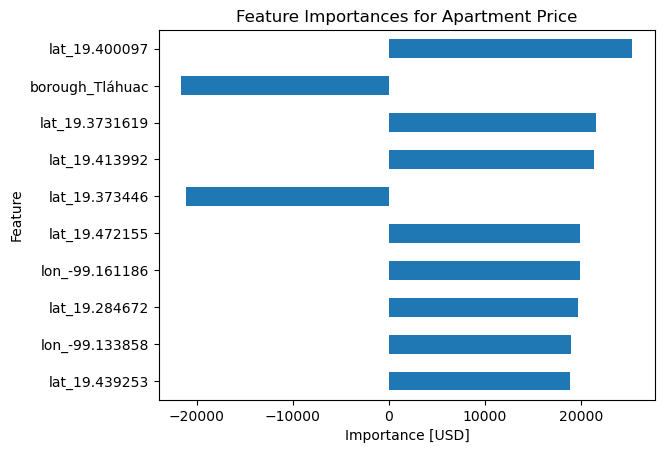

In [37]:

feat_imp.sort_values(key=abs).tail(10).plot(kind="barh")


plt.xlabel("Importance [USD]")
plt.ylabel("Feature")


plt.title("Feature Importances for Apartment Price")

fig, ax = plt.subplots()

# Create the horizontal bar plot on the axes object
feat_imp.sort_values(key=abs).tail(10).plot(kind = "barh")

# Label axes
ax.set_xlabel('Importance [USD]')
ax.set_ylabel('Feature')

# Add title
ax.set_title('Feature Importances for Apartment Price')

